The orbital parameters of the binary solar twin HIP 67620
---------------------

`radial` is a simple program designed to do a not very trivial task: simulate radial velocities of a star orbited by a massive object or "reverse engineer" radial velocity measurements to estimate the orbital parameters of the system being studied. The formalism behind it is based on https://arxiv.org/abs/1009.1738.

Our objective in this notebook is to use radial velocity data of the solar twin HIP 67620 to estimate the projected mass, separation and other orbital parameters of its companion. We start by importing the necessary packages. Notice that we will specifically import the modules `orbit`, `estimate`, and `dataset` from the `radial` package.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
from radial import orbit, estimate, dataset
%matplotlib inline

We then extract the data from the text files located in the `tests` folder. They will be stored in `RVDataSet` objects, which are defined in the `dataset` module.

In [2]:
harps = dataset.RVDataSet(file='../data/HIP67620_HARPS.dat', # File name
                          t_offset=-2.45E6,                 # Time offset (units of days)
                          rv_offset='subtract_mean',        # RV offset
                          instrument_name='HARPS',
                          target_name='HIP 67620', 
                          skiprows=1,   # Number of rows to skip in the data file
                          t_col=5,      # Column corresponding to time in the data file
                          rv_col=6,     # Column corresponding to RVs
                          rv_unc_col=7  # Column corresponding to RV ucnertainties
                         )
aat = dataset.RVDataSet(file='../data/HIP67620_AAT.dat', t_offset=-2.45E6, rv_offset='subtract_mean', 
                          instrument_name='AATPS', target_name='HIP 67620', delimiter=',')
w16 = dataset.RVDataSet(file='../data/HIP67620_WF16.dat', t_offset=-5E4, rv_offset='subtract_mean', 
                         instrument_name='W16', target_name='HIP 67620', t_col=1, 
                         rv_col=3, rv_unc_col=4)

We can visualize the radial velocities by running the function `plot()` of a given `dataset` object. For instance:

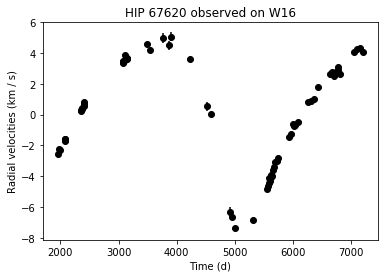

In [3]:
w16.plot()

Now that we have the data, how do we estimate the orbital parameters of the system? We use the methods and functions inside the `estimate` module. But first, we need to provide an initial guess for the orbital parameters. They are:

* `k`: radial velocity semi-amplitude $K$ (in m/s)
* `period`: orbital period $T$ (in days)
* `t0`: time of periastron passage $t_0$ (in days)
* `omega`: argument of periapse $\omega$ (in radians)
* `ecc`: eccentricity of the orbit $e$
* `gamma_X`: RV offset $\gamma$ of the dataset number $X$ (in m/s)

A first guess is usually an educated guess based on either a periodogram and/or simple visual inspection of the data.

In [17]:
# guess is a dictionary, which is a special type of "list" in python
# Instead of being indexed by a number, the items in a dictionary
# are indexed by a key (which is a string)
guess = {'k': 6000,
         'period': 4000,
         't0': 5000,
         'omega': 180 * np.pi / 180,
         'ecc': 0.3,
         'gamma_0': 0,
         'gamma_1': 0,
         'gamma_2': 0}

Now we need to instantiate a `FullOrbit` object with the datasets and our guess, as well as the parametrization option we want to use. Then, we plot it.

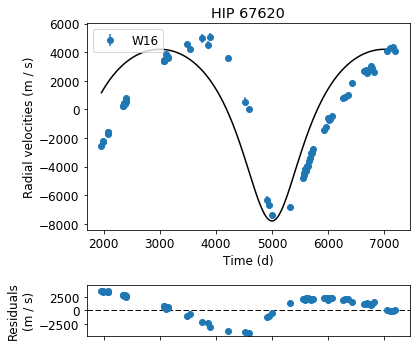

In [18]:
estim = estimate.FullOrbit(datasets=[w16], 
                           guess=guess,
                           parametrization='mc10')
plot = estim.plot_rvs(plot_guess=True, fold=False, legend_loc=2)
plt.show()

We estimate the orbital parameters of the system using the Nelder-Mead optimization algorithm implemented in the `lmfit` package. This will compute the best solution or, in other words, the one that minimizes the residuals of the fit.

It is probable that the first solutions are not good, and that is fine. Just run the estimation a couple of times until you get the satisfactory result.

In [20]:
result = estim.lmfit_orbit(update_guess=True)

log_k = 3.796355640254445
log_period = 3.5830892521078797
t0 = 4929.889242188322
omega = 2.460910562747033
ecc = 0.35830705918431627
gamma_0 = 140.3869102570369


Now let's plot the solution we obtained.

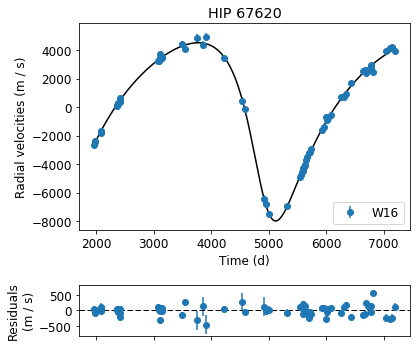

In [21]:
pylab.rcParams['font.size'] = 12
fig, gs = estim.plot_rvs(plot_guess=True, fold=False, legend_loc=4)

If the result looks good, that is great: we have the best solution of the orbit. However, we still need to estimate uncertainties for the orbital parameters. We do that using `emcee`. This is a Markov-Chain Monte Carlo (MCMC) simulation, in which we simulate a bunch of sets of orbital parameters that could still fit the data given the uncertainties of the observations, but are a little bit off from the best solution. They will make up the uncertainties of the fit. 

This simulation starts from the best solution and do random walks across the parameter space. We will provide the number of *walkers* (`nwalkers`) for the MCMC simulation, as well as the number of *steps* (`nsteps`) that each one will take. 

How do we know the number of walkers and steps to use? As a general rule of thumb, it is recommended to use at least 2 times the number of parameters for the number of walkers, and as many steps as it takes for the simulation to converge.

**Note**: We can use multiprocessing in `emcee` to make the calculations somewhat faster. For that, we need to provide the number of processing threads (in the parameter `nthreads`) of your computer. Most laptops have 2 or 4 threads.

In [23]:
estim.emcee_orbit(nwalkers=12, nsteps=1000, nthreads=4)

With that done, we plot the walkers to see how the simulation went.

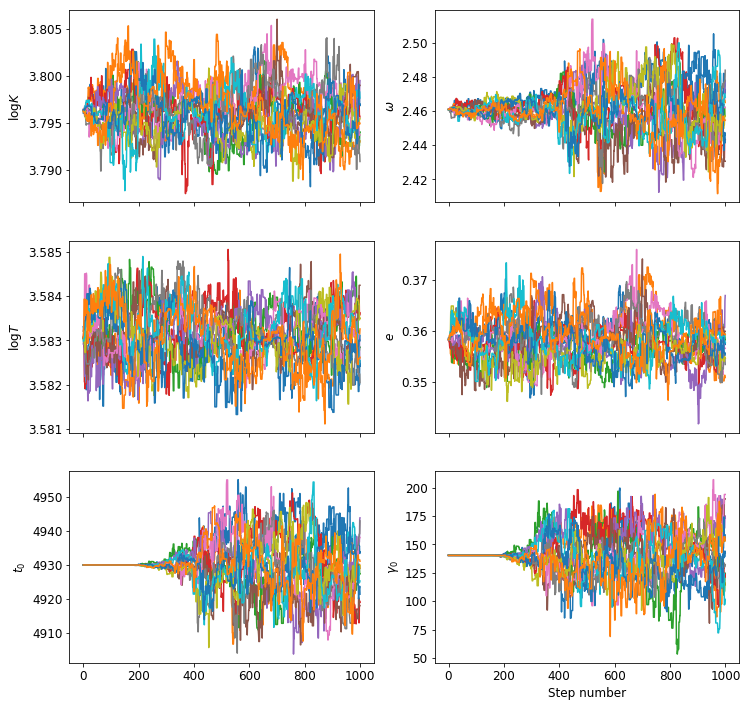

In [24]:
estim.plot_emcee_sampler()

Let's cut the beginning of the simulation (the first 500 steps) because they correspond to the *burn-in* phase.

In [25]:
estim.make_chains(500)

array([[  3.79206915e+00,   3.58343443e+00,   4.94391160e+03,
          2.48868574e+00,   3.57723904e-01,   1.11214755e+02],
       [  3.79206915e+00,   3.58343443e+00,   4.94391160e+03,
          2.48868574e+00,   3.57723904e-01,   1.11214755e+02],
       [  3.79206915e+00,   3.58343443e+00,   4.94391160e+03,
          2.48868574e+00,   3.57723904e-01,   1.11214755e+02],
       ..., 
       [  3.79502697e+00,   3.58259190e+00,   4.93141033e+03,
          2.45442169e+00,   3.59381380e-01,   1.56676983e+02],
       [  3.79502697e+00,   3.58259190e+00,   4.93141033e+03,
          2.45442169e+00,   3.59381380e-01,   1.56676983e+02],
       [  3.79492413e+00,   3.58261883e+00,   4.93097577e+03,
          2.45468347e+00,   3.59264363e-01,   1.53334958e+02]])

Now we use a corner plot to analyze the posterior distributions of the parameters, as well as the correlations between them.

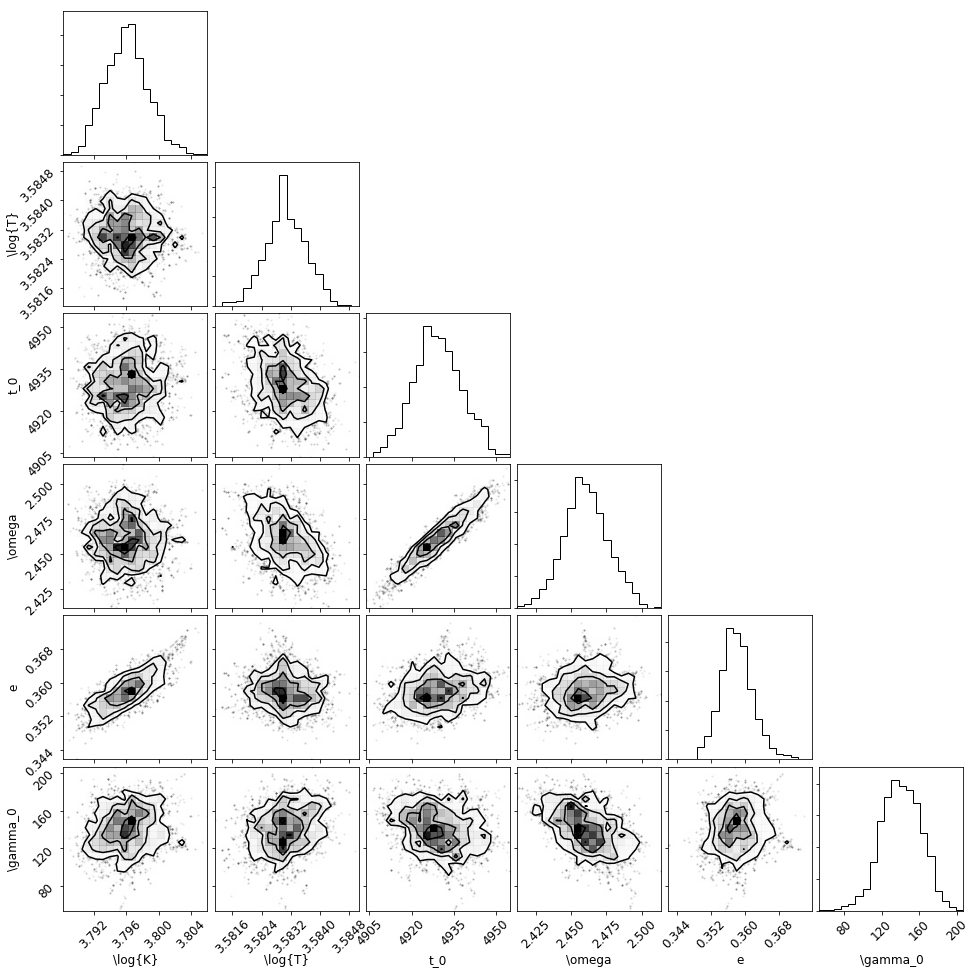

In [26]:
fig = estim.plot_corner()
plt.show()

And that should be pretty much it. Finally, we compute the orbital parameters in a human-readable fashion.

In [27]:
estim.print_emcee_result(main_star_mass=0.954, # in M_sol units
                         mass_sigma=0.006)

Raw results:
\log{K} = 3.79604^{+0.00253}_{-0.00267}
\log{T} = 3.58304^{+0.00059}_{-0.00051}
t_0 = 4928.98857^{+9.04045}_{-8.14741}
\omega = 2.45968^{+0.01688}_{-0.01410}
e = 0.35773^{+0.00381}_{-0.00342}
\gamma_0 = 140.38014^{+21.81368}_{-20.55859}

Human-friendly results:
K = 6252.32529^{+36.55906}_{-38.33474} m / s
T = 3828.56136^{+5.21390}_{-4.49659} d
t_0 = 4928.98857^{+9.04045}_{-8.14741} d
\omega = 140.92955^{+0.96732}_{-0.80800} deg
e = 0.35773^{+0.00381}_{-0.00342}  
m \sin{i}= 0.56738^{+0.00406}_{-0.00425} solMass
a= 5.50915^{+0.01158}_{-0.01146} AU
